In [1]:
%pip install pandas matplotlib scipy seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from scipy.signal import savgol_filter
from dateutil import tz

In [125]:
N_STARLINK = 'Starlink'
N_SHAW = 'Shaw'
src_dirs = ['data/trad_ping_2022-04-14', 'data/starlink_ping_2022-04-14/']

#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sns.set_context("paper", rc={"font.size":9,"axes.titlesize":9,"axes.labelsize":8, "xtick.labelsize":8})

In [112]:
from common import combine_csvs

In [113]:
df = pd.DataFrame()
for folder in src_dirs:
    for region in os.scandir(folder):
        pattern = f"{region.path}/*"
        print(pattern)
        df_temp = combine_csvs(glob.glob(pattern, recursive=True), 3)
        df_temp.index = pd.to_datetime(df_temp.index, unit='s')
        df_temp = df_temp.iloc[:,[2]]
        df_temp.rename(columns={df_temp.columns[0]: os.path.join(folder, region.name)}, inplace=True)

        df = df.merge(df_temp, how='outer', left_index=True, right_index=True)



data/trad_ping_2022-04-14/Sydney/*
data/trad_ping_2022-04-14/N. California/*
data/starlink_ping_2022-04-14/Sydney/*
data/starlink_ping_2022-04-14/N. California/*


In [114]:
df.shape[0]

10110

In [115]:
num_regs = int(len(df.columns) / 2) # One for each of Shaw vs Starlink
print(num_regs)
cols = df.columns.tolist()
df.head()

2


,data/trad_ping_2022-04-14/Sydney,data/trad_ping_2022-04-14/N. California,data/starlink_ping_2022-04-14/Sydney,data/starlink_ping_2022-04-14/N. California
2022-04-13 05:06:07,NaN,NaN,NaN,57.4
2022-04-13 05:06:08,NaN,NaN,NaN,47.8
2022-04-13 05:06:09,NaN,NaN,NaN,61.9
2022-04-13 05:06:10,NaN,NaN,NaN,52.9
2022-04-13 05:06:11,NaN,NaN,NaN,51.0


In [116]:
# https://stackoverflow.com/questions/69300483/how-to-use-markers-with-ecdf-plot
def ecdf(data, array: bool=True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    if not array:
        return pd.DataFrame({'x': x, 'y': y})
    else:
        return x, y

In [117]:
new_cols = []
for col in cols:
    region = os.path.basename(col).replace('_',' ').strip()
    new_cols.append(region)

#regions = ['Mumbai', 'Sydney', 'Singapore', 
#        'N. California', 'London', 'Bahrain', 'Sao Paulo', 'Tokyo', 'Africa']

multi_cols = [
        [N_SHAW] * num_regs + [N_STARLINK] * num_regs,
        new_cols
        ]
df.set_axis(multi_cols, axis=1, inplace=True)
df

Shaw               Starlink              
                    Sydney N. California   Sydney N. California
2022-04-13 05:06:07    NaN           NaN      NaN          57.4
2022-04-13 05:06:08    NaN           NaN      NaN          47.8
2022-04-13 05:06:09    NaN           NaN      NaN          61.9
2022-04-13 05:06:10    NaN           NaN      NaN          52.9
2022-04-13 05:06:11    NaN           NaN      NaN          51.0
...                    ...           ...      ...           ...
2022-04-15 01:06:24    NaN           NaN    243.0          63.8
2022-04-15 01:06:25    NaN           NaN    243.0          55.2
2022-04-15 01:06:26    NaN           NaN    263.0          53.8
2022-04-15 01:06:27    NaN           NaN    245.0          49.7
2022-04-15 01:06:28    NaN           NaN    258.0          39.7

[10110 rows x 4 columns]

In [118]:
# Filter
df_processed = df
#df_processed = df.loc['2022-05-13 07:13:50':'2022-05-13 7:14:18']
#df_processed = df.loc['2022-05-10 08:29:00':'2022-05-10 8:33:00']
#df_processed = df_processed.resample('H').mean()
#df_processed.to_csv('output/out.csv')
df_processed

Shaw               Starlink              
                    Sydney N. California   Sydney N. California
2022-04-13 05:06:07    NaN           NaN      NaN          57.4
2022-04-13 05:06:08    NaN           NaN      NaN          47.8
2022-04-13 05:06:09    NaN           NaN      NaN          61.9
2022-04-13 05:06:10    NaN           NaN      NaN          52.9
2022-04-13 05:06:11    NaN           NaN      NaN          51.0
...                    ...           ...      ...           ...
2022-04-15 01:06:24    NaN           NaN    243.0          63.8
2022-04-15 01:06:25    NaN           NaN    243.0          55.2
2022-04-15 01:06:26    NaN           NaN    263.0          53.8
2022-04-15 01:06:27    NaN           NaN    245.0          49.7
2022-04-15 01:06:28    NaN           NaN    258.0          39.7

[10110 rows x 4 columns]

In [ ]:
df_regs_interp = df.interpolate(method='linear')
df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,41,1))
df_regs_interp

In [119]:
df_unstacked = df_processed.unstack().reset_index(name='latency')
N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TYPE = 'Type'
df_unstacked.rename(columns={'level_0': N_TYPE, 'level_1': N_REGIONS, 'level_2': N_TIMESTAMP},
        inplace=True)
df_unstacked.dropna(inplace=True)
df_unstacked.reset_index(drop=True, inplace=True)
#df_unstacked['hour'] = df_unstacked.timestamp.dt.to_period('H')
#df_unstacked = df_unstacked.set_index(['hour', N_TIMESTAMP])
#df_unstacked = df_unstacked.pivot_table(index='hour', columns=[N_TYPE, N_REGIONS, N_TIMESTAMP], values='latency')
df_unstacked

,type,Regions,timestamp,latency
0,Shaw,Sydney,2022-04-13 05:54:05,150.0
1,Shaw,Sydney,2022-04-13 05:54:06,151.0
2,Shaw,Sydney,2022-04-13 05:54:07,156.0
3,Shaw,Sydney,2022-04-13 05:54:08,152.0
4,Shaw,Sydney,2022-04-13 05:54:09,150.0
...,...,...,...,...
29893,Starlink,N. California,2022-04-15 01:06:24,63.8
29894,Starlink,N. California,2022-04-15 01:06:25,55.2
29895,Starlink,N. California,2022-04-15 01:06:26,53.8
29896,Starlink,N. California,2022-04-15 01:06:27,49.7


In [120]:
df_cdf = df_unstacked.groupby([N_TYPE, N_REGIONS])['latency'].apply(ecdf, False)
df_cdf

x         y
type     Regions                            
Shaw     N. California 0      30.6  0.033333
                       1      31.3  0.066667
                       2      31.4  0.100000
                       3      31.6  0.133333
                       4      31.7  0.166667
...                            ...       ...
Starlink Sydney        9945  324.0  0.999598
                       9946  324.0  0.999698
                       9947  339.0  0.999799
                       9948  362.0  0.999899
                       9949  369.0  1.000000

[29898 rows x 2 columns]

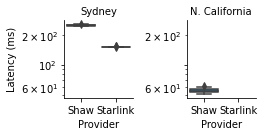

In [67]:
#df_pivot = df_unstacked.pivot_table(index=[N_REGIONS, 'timestamp'], columns='type', values='latency')
#print(df_pivot.head())

g = sns.catplot(data=df_unstacked, x='type', y='latency', col=N_REGIONS, col_wrap=4, kind='box', height=2,
        aspect=0.895, showfliers=True)
g.set(yscale='log')
g.tight_layout()
(g.set_axis_labels('Provider', 'Latency (ms)')
        .set_titles("{col_name}"))

Text(0, 0.5, 'Latency (ms)')

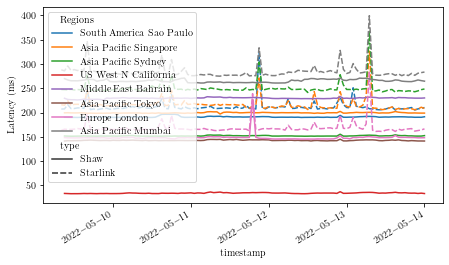

In [94]:
#fig, ax = plt.subplots(figsize=(3.5,2))
fig, ax = plt.subplots(figsize=(7.16,4))
#fig, ax = plt.subplots(figsize=(20,10))

g = sns.lineplot(data=df_unstacked, x=N_TIMESTAMP, y="latency", hue=N_REGIONS, style=N_TYPE)
g.figure.autofmt_xdate()
ax.set_ylabel('Latency (ms)')

Text(0, 0.5, 'Proportion')

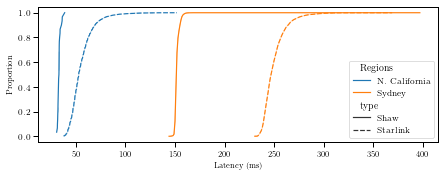

In [126]:
#fig, ax = plt.subplots(figsize=(3.5,2))
fig, ax = plt.subplots(figsize=(7.16,2.5))
#fig, ax = plt.subplots(figsize=(20,5))

#g = sns.ecdfplot(data=df_unstacked, x='latency', hue='Type Region', ax=ax)
g = sns.lineplot(data=df_cdf, x='x', y="y", hue=N_REGIONS, style=N_TYPE, ax=ax)
#g.set(xscale='log')
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Proportion')

In [ ]:
fig

In [127]:
filename = 'output/out_plot'
#fig.savefig(f'{filename}.png', bbox_inches='tight')
fig.savefig(f'{filename}.pgf', bbox_inches='tight')

In [ ]:
########
#fig, axs = plt.subplots(1, num_regs, figsize=(7.16,5))
#ax_big = fig.add_subplot(111, frameon=False)

#df_regions = []
#for i in range(num_regs):
#    df_region = df.iloc[:,[i,(num_regs+i)]]
#    boxplt = sns.boxplot(x="variable", y="value", data=pd.melt(df_region), ax=axs[i], showfliers=False)

#    raw_region = df_region.columns[0]
#    region = raw_region.split('/')[1].replace('_',' ').strip()
#    boxplt.set(xlabel=region, ylabel=None)

#    #axs[i].set(yscale='log')
#    axs[i].set_xticklabels(labels=["Shaw", "Starlink"], fontsize=9)
#    axs[i].tick_params(labelsize=9)


#ax_big.set_xlabel("Network Provider and Region", fontsize=10, labelpad=30, fontweight='bold')
#ax_big.set_ylabel("Latency (ms)", fontsize=10, labelpad=30, fontweight='bold')
#ax_big.set_yticklabels([])
#ax_big.set_xticklabels([])
#ax_big.tick_params(
#    which='both',
#    bottom=False,
#    left=False,
#    right=False,
#    top=False)
#ax_big.grid(False)
#############